In [1]:
from os.path import join, dirname, abspath
import yaml

import matplotlib.pyplot as plt

from pypsa import Network

from postprocessing.utils import *

import pickle

### Parameters

### Loading solved nets

In [2]:
main_case = '20201113_201957'
output_dir = f'../../output/mga/{main_case}/'
base_case = "base"
epsilons = [0.01, 0.02, 0.03, 0.05, 0.1]
min_cases = [f"min_eps{eps}" for eps in epsilons]
max_cases = [f"max_eps{eps}" for eps in epsilons]
cases = [base_case] + min_cases + max_cases
print(cases)
nets = dict.fromkeys(cases)
for case in cases:
    nets[case] = Network()
    nets[case].import_from_csv_folder(f"{output_dir}{case}/")


['base', 'min_eps0.01', 'min_eps0.02', 'min_eps0.03', 'min_eps0.05', 'min_eps0.1', 'max_eps0.01', 'max_eps0.02', 'max_eps0.03', 'max_eps0.05', 'max_eps0.1']


INFO:pypsa.io:Imported network  has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, links

## Problem size

### Costs

In [3]:
# Costs of generators
techs = ["ccgt", "load", "pv_utility", "ror",
         "wind_onshore", "wind_offshore"]

capex_opex = pd.DataFrame(index=["capex", "opex"], columns=cases)
costs_all = pd.DataFrame(index=["Generation", "Transmission", "Storage"], columns=cases, dtype=float)
for case in cases:
    net = nets[case]
    print(net.objective)
    cost = get_generators_cost(net).sum() + get_links_capex(net).sum() + get_storage_cost(net).sum()
    costs_all.loc["Generation", case] = get_generators_cost(net).sum()
    capex_opex.loc["capex", case] = get_links_capex(net).sum()
    capex_opex.loc["opex", case] = get_storage_opex(net).sum()
    costs_all.loc["Transmission", case] = get_links_capex(net).sum()
    costs_all.loc["Storage", case] = get_storage_cost(net).sum()
costs_all.loc["Total"] = costs_all.sum()
print(costs_all[base_case])
print(costs_all[min_cases])
print(costs_all[max_cases])


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


28.739413018298567
4.08
4.08
4.08
4.08
4.08
-46.616289910636176
-79.60458192165558
-112.59287393267515
-178.56945795471344
-343.5110327940157
Generation      0.028624
Transmission    0.000113
Storage         0.000003
Total           0.028739
Name: base, dtype: float64
              min_eps0.01  min_eps0.02  min_eps0.03  min_eps0.05  min_eps0.1
Generation       0.028911     0.029089     0.029267     0.029658    0.030496
Transmission     0.000000     0.000000     0.000000     0.000000    0.000000
Storage          0.000115     0.000226     0.000334     0.000515    0.001113
Total            0.029027     0.029314     0.029601     0.030173    0.031609
              max_eps0.01  max_eps0.02  max_eps0.03  max_eps0.05  max_eps0.1
Generation       0.028624     0.028624     0.028624     0.028624    0.028624
Transmission     0.000400     0.000688     0.000975     0.001550    0.002987
Storage          0.000003     0.000003     0.000003     0.000003    0.000003
Total            0.029027     0.029314

### Number of points

In [4]:
# Cost increase vs number of points
# Min cases
print((costs_all.loc["Total", min_cases]/costs_all.loc["Total", cases[0]] - 1))
# Maw cases
print((costs_all.loc["Total", max_cases]/costs_all.loc["Total", cases[0]] - 1))

min_eps0.01    0.010000
min_eps0.02    0.019994
min_eps0.03    0.029972
min_eps0.05    0.049898
min_eps0.1     0.099850
Name: Total, dtype: float64
max_eps0.01    0.010000
max_eps0.02    0.019999
max_eps0.03    0.029999
max_eps0.05    0.049998
max_eps0.1     0.099995
Name: Total, dtype: float64


## Capacities

              base min_eps0.01 min_eps0.02 min_eps0.03 min_eps0.05 min_eps0.1
ccgt            16          16          16          16          16         16
pv_utility       0           1           2           0           3          1
wind_onshore    48          11          11          16          15         27
wind_offshore   17          38          38          39          38         34
AC               3           1           1           1           1          1
Li-ion           0           2           4           6          10         21
              base max_eps0.01 max_eps0.02 max_eps0.03 max_eps0.05 max_eps0.1
ccgt            16          16          16          16          16         16
pv_utility       0           0           0           0           0          0
wind_onshore    48          48          48          48          48         48
wind_offshore   17          17          17          17          17         17
AC               3           7          12          16          

Text(0.5, 1.0, 'max')

<Figure size 432x288 with 0 Axes>

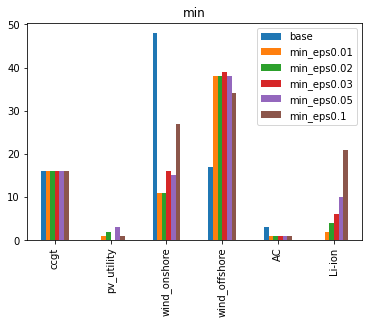

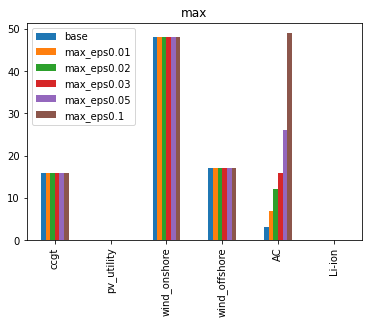

In [7]:
techs = ["ccgt", "pv_utility", "wind_onshore", "wind_offshore",
         "AC", "Li-ion"]
capacities_df = pd.DataFrame(columns=cases, index=techs)
capacities_init_df = pd.DataFrame(columns=cases, index=techs)
for case in cases:
    net = nets[case]
    capacities = pd.concat([get_generators_capacity(net)["final"],
                            get_links_capacity(net)["new [TWkm]"] + get_links_capacity(net)["init [TWkm]"],
                            get_storage_energy_capacity(net)["new [GWh]"]])
    for tech in techs:
        capacities_df.loc[tech, case] = capacities[capacities.index.str.startswith(tech)].sum().round()
    # capacities_df[case] = capacities[techs].round().values
    capacities = pd.concat([get_generators_capacity(net)["init"],
                            get_links_capacity(net)["init [TWkm]"],
                            get_storage_power_capacity(net)["init [GW]"]])
    capacities_init_df[case] = capacities[techs].round().values
min_capacities_df = capacities_df[[base_case] + min_cases]
print(min_capacities_df)
max_capacities_df = capacities_df[[base_case] + max_cases]
print(max_capacities_df)
plt.figure()
min_capacities_df.plot(kind="bar")
#plt.legend("")
plt.title("min")
#capacities_init_df.plot(ax=axes[0], kind="bar", color='k', alpha=0.5)
max_capacities_df.plot(kind="bar")
#plt.legend("")
plt.title("max")
#plt.xticks(rotation="45")
# plt.savefig(f"capacities_{year}.png", bbox_inches="tight")

### Generation

In [17]:
techs = ['wind_onshore_national', 'wind_offshore_national', 'pv_residential_national', 'pv_utility_national']

generation_df = pd.DataFrame(columns=cases, index=techs)
ccgt_generation_df = pd.DataFrame(columns=cases, index=["Capacity (GW)", "Generation (TWh)"], dtype=float)
for case in cases:
    print(case)
    net = nets[case]
    res_gens = net.generators[net.generators.type.isin(techs)]
    total_cap = res_gens.p_nom_opt.sum()
    total_gen = (net.generators_t.p[res_gens.index]).sum().sum()
    print(f"Total capacity: {total_cap:.2f}")
    print(f"Total generation: {total_gen/1e3:.2f}")
    ccgt_gens = net.generators[net.generators.type == 'ccgt']
    ccgt_generation_df.loc["Capacity (GW)", case] = ccgt_gens.p_nom_opt.sum()
    ccgt_generation_df.loc["Generation (TWh)", case] = net.generators_t.p[ccgt_gens.index].sum().sum()/1e3
    print()
print(ccgt_generation_df.round(2))

base
Total capacity: 0.00
Total generation: 0.00

min
Total capacity: 0.00
Total generation: 0.00

max
Total capacity: 0.00
Total generation: 0.00

                   base    min    max
Capacity (GW)     15.93  15.96  15.93
Generation (TWh)   0.18   0.19   0.18


### Potential

### Transmission

In [18]:
# Capacity overall
capacities_df = pd.DataFrame(index=["AC", "DC"], columns=["init"] + cases)
for case in cases:
    net = nets[case]
    capacities = get_links_capacity(net)
    capacities_df["init"] = capacities["init [TWkm]"]
    capacities_df[case] = capacities["new [TWkm]"]
capacities_df.loc["Total"] = capacities_df.loc["AC"] + capacities_df.loc["DC"]
print(f"Added capacity:\n {capacities_df}")

# In Europe
"""
capacities_eu_df = pd.DataFrame(index=["AC", "DC"], columns=["init"] + cases)
outside_nodes = regions_dict["GLIS"] + regions_dict["NA"]
print(outside_nodes)
for case in cases:
    net = nets[case]
    capacities = get_links_capacity(net, outside_nodes)
    capacities_eu_df["init"] = capacities["init [TWkm]"]
    capacities_eu_df[case] = capacities["new [TWkm]"]
print(f"Added capacity:\n {capacities_eu_df}")
"""
0

Added capacity:
            init      base           min        max
AC     0.743077  1.818419 -1.570097e-12  10.318093
DC          NaN       NaN           NaN        NaN
Total       NaN       NaN           NaN        NaN


0

In [ ]:
# Maps of flows
from postprocessing.plotly import SizingPlotly

for case in cases:
    net = nets[case]
    sp = SizingPlotly(net)
    #fig = sp.plot_topology()
    #fig = sp.plot_capacity("init")
    #fig.show()
    fig = sp.plot_capacity("final")
    fig.show()
    #fig.write_image(f"transmission_capacity_{case}.png", dpi=300)
    # fig.write_html(f"{case}_topology_heatmap.html", auto_open=True)

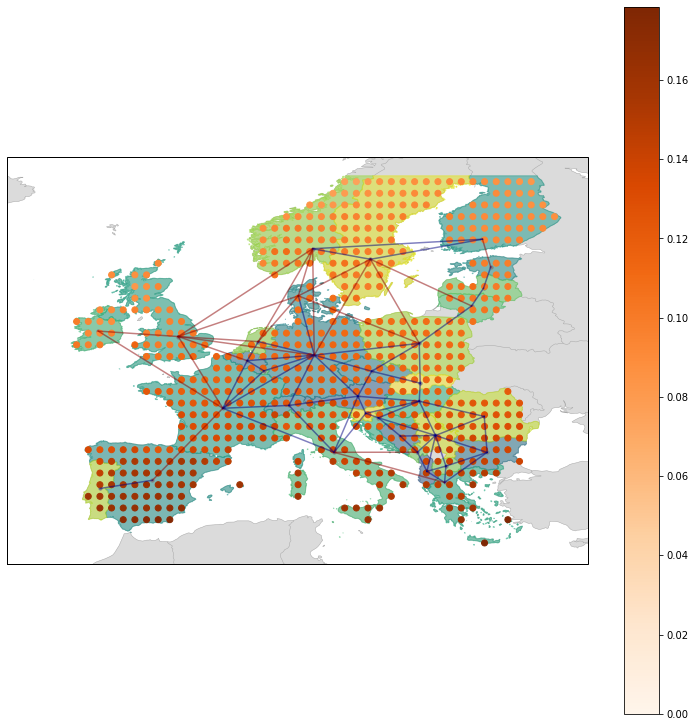

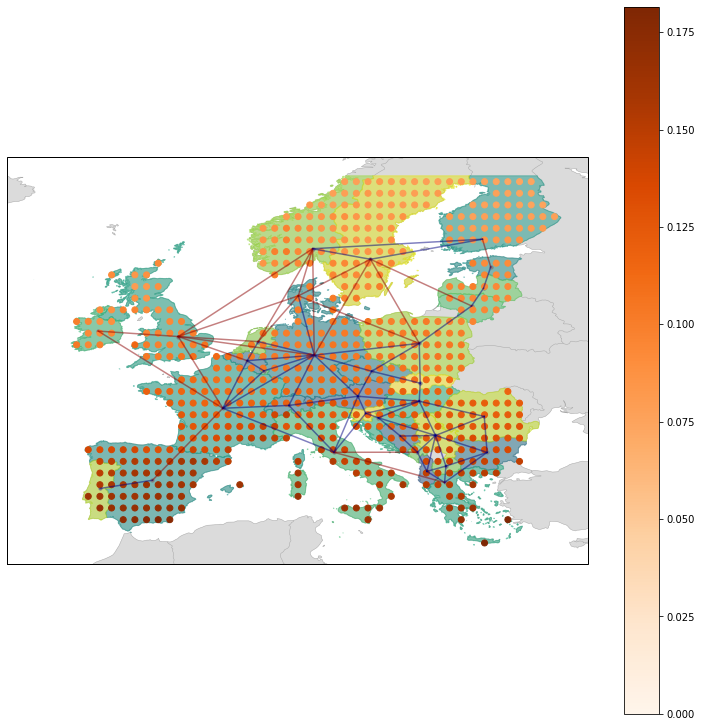

In [10]:
from iepy.topologies.core.plot import plot_topology
import shapely.wkt

# !!! Why are sites exploited at the maximum of their potential????

min_cap = 1e-6
for case in cases_short:
    net = nets[case]
    net.buses["onshore_region"] = net.buses.region.apply(lambda x: shapely.wkt.loads(x))
    net.buses["offshore_region"] = None
    ax = plot_topology(net.buses, net.links)
    techs = ["pv_residential_national"]
    res_generators = net.generators[(net.generators.type.isin(techs)) & (net.generators.p_nom_opt >= min_cap)]
    x = res_generators.loc[res_generators.index, "x"].values
    y = res_generators.loc[res_generators.index, "y"].values
    #values = res_generators.p_nom_opt.values
    #values = (res_generators.p_nom_opt/res_generators.p_nom_max).values
    values = net.generators_t.p_max_pu[res_generators.index].mean()
    map1 = ax.scatter(x, y, c=values, cmap='Oranges', vmin=0)
    plt.colorbar(map1, ax=ax)

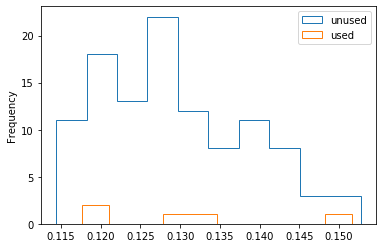

<Figure size 432x288 with 0 Axes>

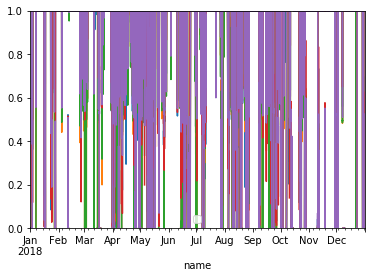

In [242]:
# Percentage of sites with max capacity
min_cap = 0
for case in cases_short[1:]:
    net = nets[case]
    techs = ["pv_utility_national"]
    res_generators = net.generators[(net.generators.type.isin(techs)) & (net.generators.p_nom_opt >= min_cap)]
    values = res_generators.p_nom_opt.round(2)
    #values = (res_generators.p_nom_opt/res_generators.p_nom_max).round(2)
    not_full_potential = values[values < 1]
    full_potential = values[values >= 1]
    plt.figure()
    net.generators_t.p_max_pu[not_full_potential.index].mean().plot(kind="hist", histtype="step")
    net.generators_t.p_max_pu[full_potential.index].mean().plot(kind="hist", histtype="step")
    plt.legend(["unused", "used"])
    # Percentage of capacity factor used
    max_generation = net.generators_t.p_max_pu[full_potential.index]*net.generators.loc[full_potential.index].p_nom_opt
    generation = net.generators_t.p[full_potential.index]
    plt.figure()
    (generation/max_generation).plot()
    plt.ylim([0, 1])
    plt.legend("")
    #values = net.generators_t.p_max_pu[res_generators.index].mean()
    #values.plot(kind="hist", cumulative=True, histtype="step", density=True)
    #plt.xlim([0, 1])

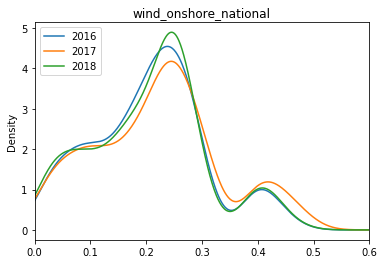

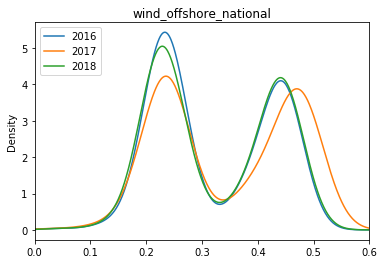

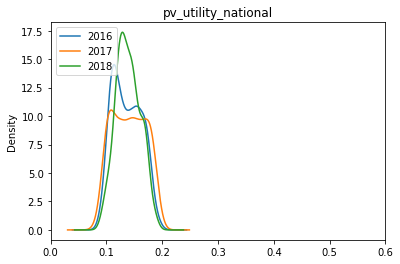

In [56]:
# Res aggregated signal
techs = ["wind_onshore_national", "wind_offshore_national", "pv_utility_national"]
min_cap = 0
cases_tested = cases_short
for tech in techs:
    plt.figure()
    for case in cases_tested:
        net = nets[case]
        res_gens = net.generators[(net.generators.type == tech) & (net.generators.p_nom_opt >= min_cap)]
        # Capacity factor average per site
        res_gens_p_max_pu = net.generators_t.p_max_pu[res_gens.index]
        res_gens_p_max_pu_agg = res_gens_p_max_pu.mean(axis=0)
        # Total generation potential (over the time period considered) per site
        #res_gens_p_max_pu = net.generators_t.p_max_pu[res_gens.index]*res_gens.p_nom_max
        #res_gens_p_max_pu_agg = res_gens_p_max_pu.sum(axis=0)
        #res_gens_p_max_pu_agg.plot(kind="hist", bins=50, histtype="step")
        res_gens_p_max_pu_agg.plot(kind="kde")

    plt.legend(cases_tested, loc="upper left")
    plt.xlim([0, 0.6])
    plt.title(tech)

In [57]:
# Res penetration
techs = ["wind_onshore_national", "wind_offshore_national", "pv_utility_national", "pv_residential_national"]
time_agg = net.loads_t.p.index
load_grouped = net.loads_t.p.groupby(time_agg).sum().sum(axis=1)
load = net.loads_t.p.sum().sum()
# print(load)
print("Yearly RES penetration")
for case in cases_short:
    net = nets[case]
    res_gens = net.generators[net.generators.type.isin(techs)]
    res_gens_p = net.generators_t.p[res_gens.index]
    print(f"{res_gens_p.sum().sum()*100/load:.2f}")
    res_prod_grouped = res_gens_p.groupby(time_agg).sum().sum(axis=1)
    print((res_prod_grouped/load_grouped).mean())
    #(res_prod_grouped/load_grouped).plot(kind="kde")
    (res_prod_grouped/load_grouped).plot(kind="hist", density="True", cumulative="True", histtype='step', bins=1000)
plt.legend(cases, loc="upper left")

Yearly RES penetration
83.81


ValueError: Grouper and axis must be same length

In [148]:
# Comparing site in siting runs vs no siting run
techs = ["wind_onshore_national", "wind_offshore_national", "pv_utility_national", "pv_residential_national"]
nositing_net = nets[cases_short[0]]
nositing_res_gens = nositing_net.generators[nositing_net.generators.type.isin(techs)]
for case in cases_short[1:]:
    net = nets[case]
    res_gens = net.generators[net.generators.type.isin(techs)]
    # Compare p_nom_max
    p_nom_max_diff = nositing_res_gens.loc[res_gens.index, "p_nom_max"] - res_gens["p_nom_max"]
    print("Sites with different p_nom_max: ", p_nom_max_diff[p_nom_max_diff != 0])
    # Compare p_nom_min
    p_nom_min_diff = nositing_res_gens.loc[res_gens.index, "p_nom_min"] - res_gens["p_nom_min"]
    print("Sites with different p_nom_min: ", p_nom_min_diff[p_nom_min_diff != 0])
    p_diff = nositing_net.generators_t.p_max_pu[res_gens.index] - net.generators_t.p_max_pu[res_gens.index]
    locs_with_diff = res_gens.index[(p_diff != 0).sum() != 0]
    print(locs_with_diff)

Sites with different p_nom_max:  Series([], Name: p_nom_max, dtype: float64)
Sites with different p_nom_min:  Series([], Name: p_nom_min, dtype: float64)
Index([], dtype='object', name='name')
Sites with different p_nom_max:  Series([], Name: p_nom_max, dtype: float64)
Sites with different p_nom_min:  Series([], Name: p_nom_min, dtype: float64)
Index([], dtype='object', name='name')
Sites with different p_nom_max:  Series([], Name: p_nom_max, dtype: float64)
Sites with different p_nom_min:  Series([], Name: p_nom_min, dtype: float64)
Index([], dtype='object', name='name')


Total cap: 1120.983 GW
Total gen: 66719.670 TWh

hour
Common sites cap: 880.687 (78.56%)
Common sites gen: 60244.931 (90.30%)

day
Common sites cap: 992.019 (88.50%)
Common sites gen: 64055.682 (96.01%)

week
Common sites cap: 922.978 (82.34%)
Common sites gen: 62097.584 (93.07%)


Capacity
                           hour     day    week
wind_onshore_national    100.00   92.77   93.53
wind_offshore_national   100.00  100.00  100.00
pv_utility_national       57.64   86.76   74.71
pv_residential_national    0.00   30.78    0.00

Generation
                          hour     day    week
wind_onshore_national    100.0   96.24   98.09
wind_offshore_national   100.0  100.00  100.00
pv_utility_national       80.7   97.69   93.10
pv_residential_national    0.0   37.04    0.00


In [78]:
# Are common sites used similarly?
techs = ["wind_onshore_national", "wind_offshore_national", "pv_utility_national", "pv_residential_national"]
nositing_net = nets[cases[0]]
min_cap = 1e-3
nositing_res_gens = nositing_net.generators[(nositing_net.generators.type.isin(techs)) 
                                            & (nositing_net.generators.p_nom_opt > min_cap)]
nositing_set = set(nositing_res_gens.index)

for case in cases[1:]:
    print()
    print(case)
    net = nets[case]
    res_gens = net.generators[(net.generators.type.isin(techs))]# & (net.generators.p_nom_opt > min_cap)]
    siting_set = set(res_gens.index)
    common_set = nositing_set.intersection(siting_set)
    # Capacity
    common_sites_cap_1_stage = nositing_res_gens.loc[list(common_set)].p_nom_opt.sum()
    common_sites_cap_2_stage = res_gens.loc[list(common_set)].p_nom_opt.sum()
    print(f"Capacity in common sites (1 vs 2): {common_sites_cap_1_stage:.3f} - {common_sites_cap_2_stage:.3f}")
    # Generation
    common_sites_gen_1_stage = (nositing_net.generators_t.p[list(common_set)]*nositing_res_gens.loc[list(common_set)].p_nom_opt).sum().sum()
    common_sites_gen_2_stage = (net.generators_t.p[list(common_set)]*res_gens.loc[list(common_set)].p_nom_opt).sum().sum()
    print(f"Gen from common sites (1 vs 2): {common_sites_gen_1_stage/1e3:.3f} - {common_sites_gen_2_stage/1e3:.3f}")
    


siting_day_0.9
Capacity in common sites (1 vs 2): 993.778 - 1044.643
Gen from common sites (1 vs 2): 28627.542 - 30874.971

siting_day_0.8
Capacity in common sites (1 vs 2): 926.939 - 977.175
Gen from common sites (1 vs 2): 27482.913 - 29242.074

siting_week_0.8
Capacity in common sites (1 vs 2): 782.845 - 789.588
Gen from common sites (1 vs 2): 24954.540 - 25680.253


In [104]:
# Comparing site per site?
techs = ["wind_onshore_national", "wind_offshore_national", "pv_utility_national", "pv_residential_national"]
nositing_net = nets[cases[0]]
min_cap = 1e-3
nositing_res_gens = nositing_net.generators[(nositing_net.generators.type.isin(techs)) 
                                            & (nositing_net.generators.p_nom_opt > min_cap)]
nositing_set = set(nositing_res_gens.index)

percentage_diff = pd.DataFrame(columns=cases[1:], index=["1GW", "1MW", "1kW", "1W"], dtype=float)
for case in cases[1:]:
    print()
    print(case)
    net = nets[case]
    res_gens = net.generators[(net.generators.type.isin(techs))]# & (net.generators.p_nom_opt > min_cap)]
    siting_set = set(res_gens.index)
    common_set = nositing_set.intersection(siting_set)
    # Capacity
    common_sites_cap_1_stage = nositing_res_gens.loc[list(common_set)].p_nom_opt
    common_sites_cap_2_stage = res_gens.loc[list(common_set)].p_nom_opt
    cap_diff = (common_sites_cap_1_stage - common_sites_cap_2_stage) #.abs()
    for v, s in [(1, "1GW"), (1e-3, "1MW"), (1e-6, "1kW"), (1e-9, "1W")]:
        cap_diff_ = cap_diff[cap_diff.abs() > v]
        percentage_diff.loc[s, case] = (1-len(cap_diff_)/len(common_set))*100
        
        #print(f"Diff of capacity: {cap_diff.abs().sum():.3f} out of ({common_sites_cap_1_stage.sum():.3f})")
        #print(f"Number of sites with diff capacity: {len(cap_diff_)} (out of {len(common_set)} common sites)")
        """
        plt.figure()
        cap_diff.plot(kind="hist", histtype="step", cumulative=True, bins=len(cap_diff), density=True)
        plt.xlabel("Capacity difference (1 stage - 2 stage) (GW)")
        plt.title(case)
        """
        # Generation
        #common_sites_gen_1_stage = (nositing_net.generators_t.p[list(common_set)]*nositing_res_gens.loc[list(common_set)].p_nom_opt)
        #common_sites_gen_2_stage = (net.generators_t.p[list(common_set)]*res_gens.loc[list(common_set)].p_nom_opt)
        #gen_diff = (common_sites_gen_1_stage - common_sites_gen_2_stage).abs().sum()
        #print(f"Diff of generation: {gen_diff.sum()/1e3:.3f} (out of {common_sites_gen_1_stage.sum().sum()/1e3:.3f})")
        # print(f"Number of sites with diff generation: {(gen_diff > 1).sum()}")    
        
print(f"Percentage of points with capacity difference below:\n{percentage_diff.round(2)}")


siting_1.0_day_0.9

siting_1.0_week_0.9
Percentage of points with capacity difference below:
     siting_1.0_day_0.9  siting_1.0_week_0.9
1GW               97.71                99.49
1MW               97.18                99.49
1kW               97.00                99.32
1W                96.83                99.15


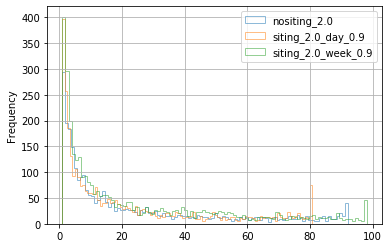

In [44]:
# CCGT usage
for case in cases:
    net = nets[case]
    ccgt_gens = net.generators[net.generators.type == "ccgt"]
    ccgt_p = net.generators_t.p[ccgt_gens.index]
    ccgt_p_sum = ccgt_p.sum(axis=1)
    ccgt_p_sum_pos = ccgt_p_sum[ccgt_p_sum >= 1]
    ccgt_p_sum_pos.plot(kind="hist", bins=100, alpha=0.5, histtype="step")
    # ccgt_p_sum_pos.plot(kind="kde", alpha=0.8)
plt.legend(cases)
plt.grid()

In [43]:
# Storage
techs = ["Li-ion", "phs"]
cycles = pd.DataFrame(columns=cases, index=techs)
for case in cases:
    net = nets[case]
    for tech in techs:
        sus = net.storage_units[net.storage_units.type == tech]
        capacity = (sus.p_nom_opt * sus.max_hours).sum()
        su_ps = net.storage_units_t.p[sus.index]
        intake = -su_ps.where(su_ps < 0, 0).sum().sum()
        cycles.loc[tech, case] = intake/capacity
print(cycles)

       nositing_2.0 siting_2.0_day_0.9 siting_2.0_week_0.9
Li-ion       475.46            371.934             390.362
phs         55.8522            52.6221             49.7098


In [95]:
import itertools
from geopy import distance
techs = ["wind_onshore_national", "wind_offshore_national", "pv_utility_national", "pv_residential_national"]
nositing_net = nets[cases[0]]
min_cap = 1e-3

for case in cases_short[1:]:
    print('----------------')    
    print(f'Run {case}')
    net = nets[case]
    min_distances = {k: [] for k in techs}
    for tech in techs:
        
        nositing_res_gens = nositing_net.generators[(nositing_net.generators.type == tech)
                                            & (nositing_net.generators.p_nom_opt > min_cap)]
        nositing_set = set(nositing_res_gens.index)
    
        res_gens = net.generators[net.generators.type == tech]# & (net.generators.p_nom_opt > min_cap)]
        siting_set = set(res_gens.index)
        intersection = nositing_set.intersection(siting_set)
        min_distances[tech].extend(list(itertools.repeat(0, len(intersection))))
        sites_excl_one = nositing_set.difference(siting_set)
        sites_excl_two = siting_set.difference(nositing_set)
        all_pairs = list(itertools.product(sites_excl_one, sites_excl_two))
        if not len(all_pairs) and len(sites_excl_one):
            print(f'All {tech} sites picked in siting stage are also in the one-stage set. {len(sites_excl_one)} sites less in the siting stage.')
        elif not len(all_pairs) and len(sites_excl_two):
            print(f'All {tech} sites picked in one stage were picked in the siting stage. {len(sites_excl_two)} sites less in the one-stage.')
        elif len(all_pairs):
            df_pairs = pd.DataFrame(columns=['site1', 'site2', 'dist'], index=np.arange(len(all_pairs)))
            for i, t in enumerate(all_pairs):
                df_pairs.loc[i, 'site1'] = tuple(nositing_res_gens.loc[t[0], ["x", "y"]])
                df_pairs.loc[i, 'site2'] = tuple(res_gens.loc[t[1], ["x", "y"]])
                df_pairs.loc[i, 'dist'] = distance.distance(df_pairs.loc[i, 'site1'], df_pairs.loc[i, 'site2']).km
            while df_pairs.shape[0] > 0:
                df_mindist = df_pairs[df_pairs.dist == df_pairs.dist.min()].iloc[0]
                min_distances[tech].append(df_mindist.dist)
                site1_out = df_mindist['site1']
                site2_out = df_mindist['site2']
                df_pairs = df_pairs[(df_pairs.site1 != site1_out) & (df_pairs.site2 != site2_out)]
            if len(sites_excl_one) > len(sites_excl_two):
                print(f'{len(sites_excl_one)-len(sites_excl_two)} one-stage {tech} sites with no match in siting')
            else:
                print(f'{len(sites_excl_two)-len(sites_excl_one)} siting {tech} sites with no match in one-stage')
        hist, bins, _ = plt.hist(min_distances[tech], bins=100, density=True, cumulative=True, histtype='step', label=tech)
    #plt.title(str(time.split('_')[-1]))
    plt.legend(ncol=2, loc='lower right')
    plt.xlabel('Distance [km]')
    plt.ylabel('Probability [-]')
    plt.show()

KeyError: 'nositing_CWE_0.5_excap'

## David's code

In [ ]:
import pandas as pd
import pickle
from os.path import join
import sys
from geopy import distance
import matplotlib.pyplot as plt
import numpy as np
import itertools

path_to_folder = '../../../git_github/replan/output/sizing/tyndp2018/'
techs = ['wind_onshore_national', 'wind_offshore_national', 'pv_residential_national', 'pv_utility_national']
# techs_final = ['w_on', 'w_off', 'pv_res', 'pv_util']
runs = []
reference_run = join(path_to_folder, 'CWE_siting_no_1deg_2018_Gurobi')
runs.append(reference_run)
comparison_run = join(path_to_folder, 'CWE_siting_yes_1deg_1.0_hour_2018_Gurobi')
runs.append(comparison_run)
# Site selection & recall and precision computation.
mindex = pd.MultiIndex.from_product([techs, ['r', 'p']], names=['tech', 'metric'])
df = pd.DataFrame(columns=techs, index=[r.split('/')[-1] for r in runs])
df_recall = pd.DataFrame(columns=mindex, index=[r.split('/')[-1] for r in runs[1:]])
for r in runs:
    try:
        with open(join(r, 'resite/resite_instance.p'), 'rb') as f:
            instance = pickle.load(f)
        sel_sites_dict = instance.sel_tech_points_dict
        all_points_dict = instance.tech_points_dict
    except FileNotFoundError:
        flp_generators_data = pd.read_csv(join(r, 'generators.csv'), index_col=0)
        sel_sites_dict = {tech: None for tech in techs}
        all_points_dict = {tech: None for tech in techs}
        for tech in techs:
            sites_tech_all = flp_generators_data[flp_generators_data.type == tech]
            all_points_dict[tech] = list(zip(sites_tech_all.x, sites_tech_all.y))
            sites_tech = sites_tech_all[sites_tech_all.p_nom_opt >= 1e-3]
            sites_tech = list(zip(sites_tech.x, sites_tech.y))
            sel_sites_dict[tech] = set(sites_tech)
        ref_sites = sel_sites_dict
    common_set_total = 0.
    fullLP_only_set_total = 0.
    reducedLP_only_set_total = 0.
    for tech in techs:
        try:
            sel_sites = set(sel_sites_dict[tech])
            sel_sites_out_of_total = str(len(sel_sites_dict[tech])) + '/' + str(len(all_points_dict[tech]))
        except KeyError:
            sel_sites = set([])
            sel_sites_out_of_total = str(0) + '/' + str(len(all_points_dict[tech]))
        df.loc[r.split('/')[-1], tech] = sel_sites_out_of_total
        common_set = set(ref_sites[tech]).intersection(sel_sites)
        common_set_total += len(common_set)
        fullLP_only_set = set(ref_sites[tech]).difference(sel_sites)
        fullLP_only_set_total += len(fullLP_only_set)
        fullLP_only_set_total += len(common_set)
        reducedLP_only_set = sel_sites.difference(set(ref_sites[tech]))
        reducedLP_only_set_total += len(reducedLP_only_set)
        reducedLP_only_set_total += len(common_set)
        try:
            recall = len(common_set) / (len(common_set) + len(fullLP_only_set))
            prec = len(common_set) / (len(common_set) + len(reducedLP_only_set))
        except ZeroDivisionError:
            recall = 0
            prec = 0
        if r == runs[1]:
            df_recall.loc[r.split('/')[-1], (tech, 'r')] = round(recall, 2)
            df_recall.loc[r.split('/')[-1], (tech, 'p')] = round(prec, 2)
    recall_overall = common_set_total / fullLP_only_set_total
    precision_overall = common_set_total / reducedLP_only_set_total
    df_recall.loc[r.split('/')[-1], ('overall', 'r')] = round(recall_overall, 3)
    df_recall.loc[r.split('/')[-1], ('overall', 'p')] = round(precision_overall, 3)
# df.columns = techs_final
print(df.to_string())
# df_recall.columns.set_levels(techs_final, level=0, inplace=True)
print(df_recall.to_string())
#  Plotting cdf of site matching (prob vs dist)
for r in runs[1:]:
    try:
        with open(join(r, 'resite/resite_instance.p'), 'rb') as f:
            instance = pickle.load(f)
        sel_sites_dict = instance.sel_tech_points_dict
        all_points_dict = instance.tech_points_dict
        min_distances = {k: [] for k in techs}
        intersection_dict = {k: [] for k in techs}
        for tech in techs:
            try:
                intersection = set(ref_sites[tech]).intersection(set(sel_sites_dict[tech]))
                min_distances[tech].extend(list(itertools.repeat(0, len(intersection))))
                sites_excl_one = set(ref_sites[tech]).difference(set(sel_sites_dict[tech]))
                sites_excl_two = set(sel_sites_dict[tech]).difference(set(ref_sites[tech]))
                all_pairs = list(itertools.product(sites_excl_one, sites_excl_two))
                intersection_dict[tech] = intersection
            except KeyError:
                print(f'{tech} had an empty set.')
                continue
            if not all_pairs:
                print(f'{tech} fully matched. {len(sites_excl_two)-len(sites_excl_one)} extra sites for siting.')
            if len(all_pairs):
                df_pairs = pd.DataFrame(columns=['site1', 'site2', 'dist'], index=np.arange(len(all_pairs)))
                for i, t in enumerate(all_pairs):
                    df_pairs.loc[i, 'site1'] = t[0]
                    df_pairs.loc[i, 'site2'] = t[1]
                    df_pairs.loc[i, 'dist'] = distance.distance(t[0], t[1]).km
                while df_pairs.shape[0] > 0:
                    df_mindist = df_pairs[df_pairs.dist == df_pairs.dist.min()].iloc[0]
                    min_distances[tech].append(df_mindist.dist)
                    site1_out = df_mindist['site1']
                    site2_out = df_mindist['site2']
                    df_pairs = df_pairs[(df_pairs.site1 != site1_out) & (df_pairs.site2 != site2_out)]
                if len(sites_excl_one) > len(sites_excl_two):
                    print(f'{len(sites_excl_one)-len(sites_excl_two)} one-stage {tech} sites with no match in siting.')
                elif len(sites_excl_one) < len(sites_excl_two):
                    print(f'{len(sites_excl_two)-len(sites_excl_one)} siting {tech} sites with no match in one-stage.')
            hist, bins, _ = plt.hist(min_distances[tech], bins=100, density=True, cumulative=True, histtype='step', label=tech)
        plt.title(r.split('/')[-1])
        plt.legend(ncol=2, loc='lower right')
        plt.xlabel('Distance [km]')
        plt.ylabel('Probability [-]')
        plt.show()
    except FileNotFoundError:
        continue
# Overall capacity matching.
print('---------------------')
flp_generators_data = pd.read_csv(join(reference_run, 'generators.csv'), index_col=0)
flp_per_tech = {tech: None for tech in techs}
for tech in techs:
    sites_tech_all = flp_generators_data[flp_generators_data.type == tech]
    sites_tech = sites_tech_all[sites_tech_all.p_nom_opt >= 1e-3]
    flp_per_tech[tech] = sites_tech.p_nom_opt.sum()
df_cap = pd.Series(index=techs)
rlp_generators_data = pd.read_csv(join(comparison_run, 'generators.csv'), index_col=0)
for tech in techs:
    sites_tech_all = rlp_generators_data[rlp_generators_data.type == tech].copy()
    sites_tech_all['location'] = list(zip(sites_tech_all.x, sites_tech_all.y))
    sites_keep = sites_tech_all[sites_tech_all['location'].isin(intersection_dict[tech])]
    share = sites_keep.p_nom_opt.sum()/flp_per_tech[tech]
    df_cap.loc[tech] = str(round(share*100, 0)) + '%/' + str(round(flp_per_tech[tech], 2)) + 'GW'
# df_cap.index = techs_final
print(df_cap.to_string())
print('---------------------')
# Plotting cdf of site-by-site capacity matching (prob vs capacity)
for tech in techs:
    flp_sites_tech_all = flp_generators_data[flp_generators_data.type == tech]
    flp_sites_tech_all = flp_sites_tech_all[flp_sites_tech_all.p_nom_opt >= 1e-3].copy()
    flp_sites_tech_all['location'] = list(zip(flp_sites_tech_all.x, flp_sites_tech_all.y))
    flp_sites_keep = flp_sites_tech_all[flp_sites_tech_all['location'].isin(intersection_dict[tech])]
    rlp_sites_tech_all = rlp_generators_data[rlp_generators_data.type == tech].copy()
    rlp_sites_tech_all['location'] = list(zip(rlp_sites_tech_all.x, rlp_sites_tech_all.y))
    rlp_sites_keep = rlp_sites_tech_all[rlp_sites_tech_all['location'].isin(intersection_dict[tech])]
    delta_cap_dict = {k: None for k in intersection_dict[tech]}
    list_vals = []
    for k in delta_cap_dict:
        diff = flp_sites_keep[flp_sites_keep['location'] == k]['p_nom_opt'] - \
                            rlp_sites_keep[rlp_sites_keep['location'] == k]['p_nom_opt']
        delta_cap_dict[k] = round(float(diff), 3)
        list_vals.append(round(float(diff), 3))
    hist, bins, _ = plt.hist(list_vals, bins=100,
                             density=True, cumulative=True, histtype='step', label=tech)
plt.title(r.split('/')[-1])
plt.legend(ncol=2, loc='upper left')
plt.xlabel('Capacity difference [GW]')
plt.ylabel('Probability [-]')
plt.show()
print('---------------------')
# Capacity and electricity generation break-down per region/country.
# regions = {'BritishIsles': ['IE', 'GB'],
#            'CWE': ['FR', 'DE', 'LU', 'NL', 'BE'],
#            'Scandinavia': ['FI', 'DK', 'SE', 'NO'],
#            'Iberia': ['ES', 'PT'],
#            'CentralSouth': ['IT', 'CH', 'AT', 'SI'],
#            'Balkans': ['RO', 'BG', 'GR', 'MK', 'ME', 'AL', 'BA', 'RS'],
#            'CentralEast': ['EE', 'LT', 'LV', 'PL', 'SK', 'CZ', 'HU']}
regions = {'FR': ['FR'],
           'DE': ['DE'],
           'LU': ['LU'],
           'NL': ['NL'],
           'BE': ['BE']}
mindex_cols = pd.MultiIndex.from_product([techs, ['cap', 'gen']], names=['tech', 'metric'])
mindex_index = pd.MultiIndex.from_product([[r for r in regions], [run.split('/')[-1] for run in runs]],
                                          names=['run', 'region'])
df_regions = pd.DataFrame(columns=mindex_cols, index=mindex_index)
for r in runs:
    cap_data = pd.read_csv(join(r, 'generators.csv'), index_col=0)
    gen_data = pd.read_csv(join(r, 'generators-p.csv'), index_col=0)
    for tech in techs:
        cap_per_tech = cap_data[cap_data.type == tech]
        for reg in regions:
            cap_per_tech_per_region = cap_per_tech[cap_per_tech.bus.isin(regions[reg])]
            df_regions.loc[(reg, r.split('/')[-1]), (tech, 'cap')] = round(cap_per_tech_per_region.p_nom_opt.sum(), 2)
            gen_per_tech_per_region = gen_data[cap_per_tech_per_region.index].copy()
            df_regions.loc[(reg, r.split('/')[-1]), (tech, 'gen')] = round(gen_per_tech_per_region.sum().sum()/1000, 2)
# df_regions.columns.set_levels(techs_final, level=0, inplace=True)
print(df_regions.to_string())
